In [15]:
# parse
import re
loss_regex = r"TrainLoss: (\d+\.\d+)"
tp_regex = r": (\d+\.\d) img\/sec"

def parse(file, regex):
    nums = []
    for line in open(file, "r").readlines():
        matches = re.search(regex, line)
        if matches:
            nums.append(float(matches.group(1)))
    return nums

def parse_loss(file):
    return parse(file, loss_regex)

def parse_tp(file):
    return parse(file, tp_regex)

In [16]:
from os import listdir
benchmarks = {}

for name in listdir("benchmarks"):
    file = f"benchmarks/{name}"
    loss = parse_loss(file)
    tp = parse_tp(file)
    benchmarks[name] = [loss, tp]

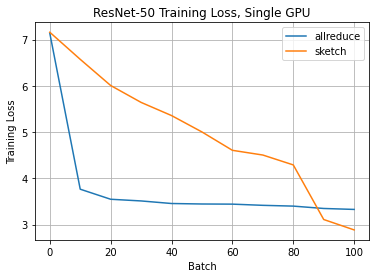

In [17]:
import numpy as np
import matplotlib.pyplot as plt
t = np.arange(0, 110, 10)
for name, [loss, _] in benchmarks.items():
    plt.plot(t, loss, label=name)

plt.xlabel("Batch")
plt.ylabel("Training Loss")
plt.grid(True)
plt.legend()
plt.title("ResNet-50 Training Loss, Single GPU")

plt.show()

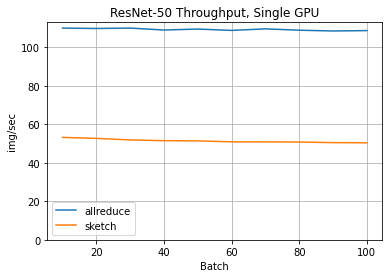

In [18]:
t = np.arange(10, 110, 10)

for name, [_, tp] in benchmarks.items():
    plt.plot(t, tp, label=name)

plt.xlabel("Batch")
plt.ylabel("img/sec")
plt.grid(True)
plt.legend()
plt.title("ResNet-50 Throughput, Single GPU")
plt.ylim(bottom=0)

plt.show()